# Detectron2 과제: Fubao Detection 🐼

과제를 시작하기 전에, 폴더 하나를 만들어서 이 코랩 파일과 Fubao_data.zip을 넣어주세요

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 내 폴더 경로로 변경
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import zipfile

# 푸고자 하는 zip 파일의 경로
zip_file_path = 'objectdetection/Fubao_data.zip'

# zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# coco 데이터셋에 Fubao 객체instance를 추가해준다.
from detectron2.data.datasets import register_coco_instances
register_coco_instances("Fubao", {}, "./Fubao_data/fubao.json", "./Fubao_data/image")
Fubao_metadata = MetadataCatalog.get("Fubao")
dataset_dicts = DatasetCatalog.get("Fubao")

[11/03 05:49:52 d2.data.datasets.coco]: Loaded 27 images in COCO format from ./Fubao_data/fubao.json


train dataset의 푸바오 이미지와 bbox를 살짝 확인해줍니다

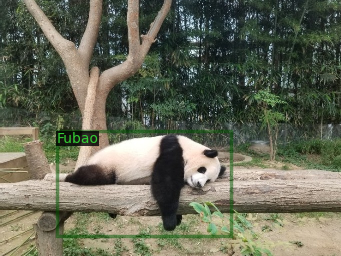

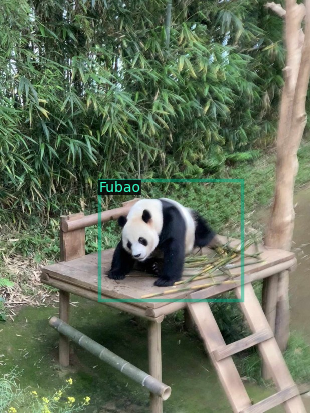

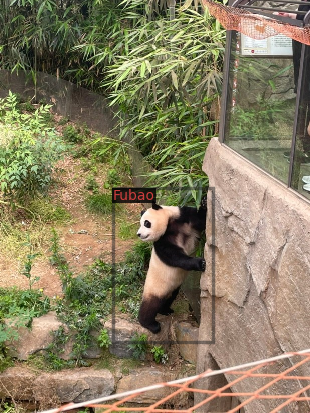

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):

    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=Fubao_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


모델 종류 확인: train time, boxAP 등을 보고 원하는 모델을 선택해서 넣기.
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

코드에 입력할 정확한 yaml 파일의 이름은 코드를 돌리는 폴더>detectron2>configs>COCO-Detection을 참고

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("Fubao",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

# batch size, learning rate, max iteration, number of class 지정 #

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 50
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/03 05:50:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:02, 114MB/s]                            
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/03 05:50:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/03 05:50:20 d2.utils.events]:  eta: 0:00:09  iter: 19  total_loss: 1.409  loss_cls: 0.5103  loss_box_reg: 0.9696  loss_rpn_cls: 0.0009041  loss_rpn_loc: 0.003226    time: 0.3281  last_time: 0.2395  data_time: 0.0189  last_data_time: 0.0044   lr: 0.00038062  max_mem: 2051M
[11/03 05:50:32 d2.utils.events]:  eta: 0:00:03  iter: 39  total_loss: 0.9441  loss_cls: 0.12  loss_box_reg: 0.8085  loss_rpn_cls: 0.0001676  loss_rpn_loc: 0.003588    time: 0.3730  last_time: 0.3908  data_time: 0.0051  last_data_time: 0.0032   lr: 0.00078022  max_mem: 2051M
[11/03 05:50:42 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 0.7005  loss_cls: 0.07703  loss_box_reg: 0.6055  loss_rpn_cls: 7.879e-05  loss_rpn_loc: 0.003005    time: 0.3539  last_time: 0.2647  data_time: 0.0055  last_data_time: 0.0033   lr: 0.00098002  max_mem: 2051M
[11/03 05:50:42 d2.engine.hooks]: Overall training speed: 48 iterations in 0:00:16 (0.3539 s / it)
[11/03 05:50:42 d2.engine.hooks]: Total training time: 0:00:27 (0:00:

trained model의 가중치를 불러와서 test image에 대해 object detection 해보기 -> 결과 확인!

In [ ]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("Fubao", )
predictor = DefaultPredictor(cfg)

[11/03 05:50:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[262.6709, 133.4565, 467.1723, 369.4077]], device='cuda:0')), scores: tensor([0.9926], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


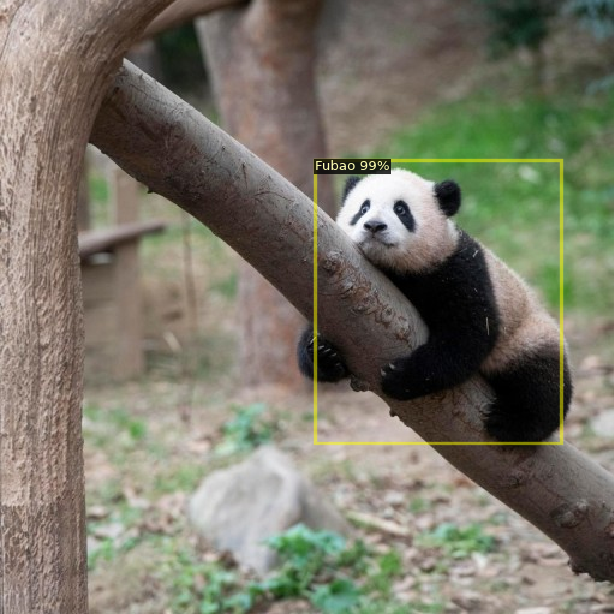

In [ ]:
path1 = "./Fubao_data/test/14.jpeg"

im = cv2.imread(path1)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
print(outputs)
v = v.draw_instance_predictions(outputs['instances'].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])


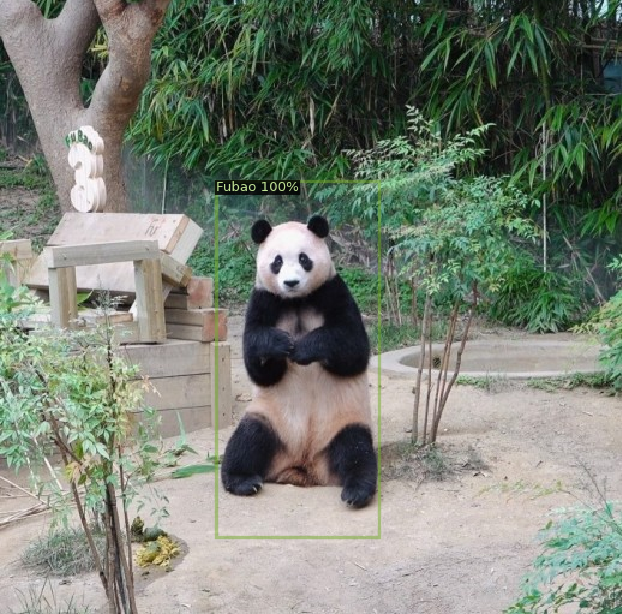

In [ ]:
path2 = "./Fubao_data/test/18.jpeg"

im = cv2.imread(path2)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

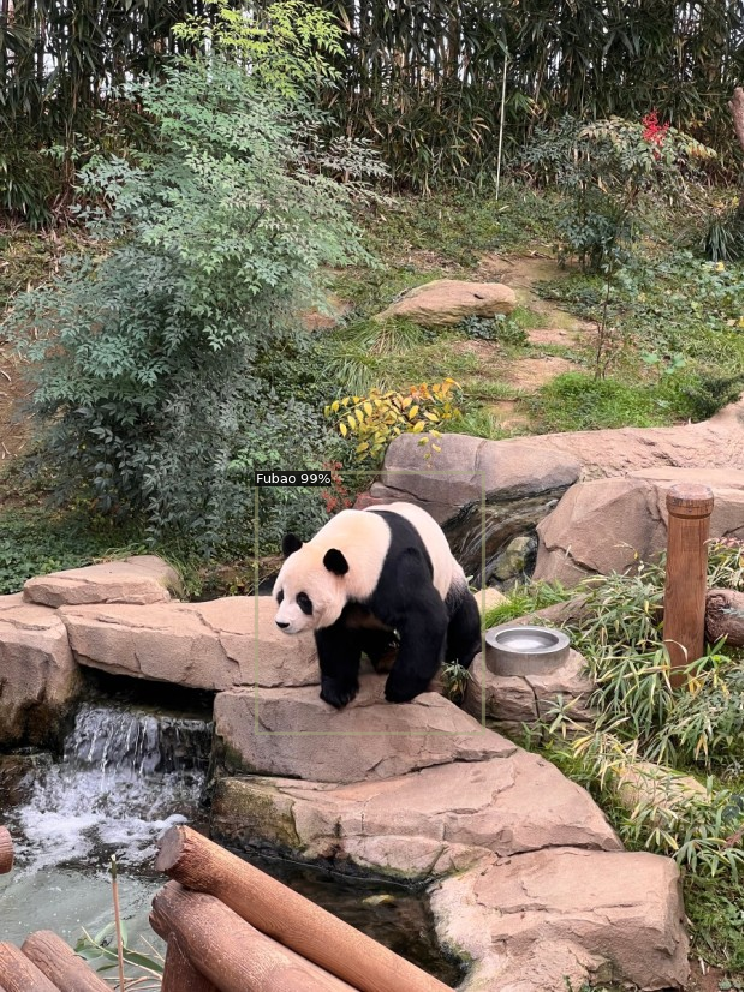

In [ ]:
path3 = "./Fubao_data/test/19.jpeg"

im = cv2.imread(path3)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])